In [152]:
from glob import glob

model_result_paths = glob("./data/judgements/*gpt-4.1/*/*.json")

In [153]:
eval_dataset_dict = {
    "elyza__ELYZA-tasks-100": "ELYZA-tasks-100",
    "yuzuai__rakuda-questions": "Rakuda",
    "lightblue__tengu_bench": "Tengu-Bench",
    "shisa-ai__ja-mt-bench-1shot": "MT-Bench",
}

In [154]:
import pandas as pd
import os

all_result_dfs = []

for model_result_path in model_result_paths:
    temp_df = pd.read_json(model_result_path, lines=True)
    print(f"Processing {model_result_path} with {len(temp_df)} rows")
    print(model_result_path.split(os.sep))
    temp_df["judge_model"] = model_result_path.split(os.sep)[1]
    temp_df["eval_dataset"] = eval_dataset_dict[model_result_path.split(os.sep)[2]]
    temp_df["model_name"] = model_result_path.split(os.sep)[3].replace(".json", "")
    
    all_result_dfs.append(temp_df)

Processing ./data/judgements\judge_gpt-4.1\elyza__ELYZA-tasks-100\aya-expanse-32b-abliterated.json with 100 rows
['./data/judgements', 'judge_gpt-4.1', 'elyza__ELYZA-tasks-100', 'aya-expanse-32b-abliterated.json']
Processing ./data/judgements\judge_gpt-4.1\elyza__ELYZA-tasks-100\gpt-4o.json with 100 rows
['./data/judgements', 'judge_gpt-4.1', 'elyza__ELYZA-tasks-100', 'gpt-4o.json']
Processing ./data/judgements\judge_gpt-4.1\elyza__ELYZA-tasks-100\mistral-small-3.2-24b-instruct-2506.json with 100 rows
['./data/judgements', 'judge_gpt-4.1', 'elyza__ELYZA-tasks-100', 'mistral-small-3.2-24b-instruct-2506.json']
Processing ./data/judgements\judge_gpt-4.1\elyza__ELYZA-tasks-100\qwen3-32b.json with 100 rows
['./data/judgements', 'judge_gpt-4.1', 'elyza__ELYZA-tasks-100', 'qwen3-32b.json']
Processing ./data/judgements\judge_gpt-4.1\elyza__ELYZA-tasks-100\shisa-v2-mistral-small-24b.json with 100 rows
['./data/judgements', 'judge_gpt-4.1', 'elyza__ELYZA-tasks-100', 'shisa-v2-mistral-small-24b.j

In [155]:
import pandas as pd
import json

all_result_dfs = []

for model_result_path in model_result_paths:
    try:
        # Try the standard pandas read_json first
        temp_df = pd.read_json(model_result_path, lines=True)
    except ValueError as e:
        print(f"Error reading {model_result_path}: {e}")
        print("Attempting alternative parsing method...")
        try:
            # Try manual parsing as fallback
            with open(model_result_path, 'r', encoding='utf-8') as f:
                json_lines = []
                for i, line in enumerate(f):
                    try:
                        # Attempt to parse each line individually
                        if line.strip():  # Skip empty lines
                            json_obj = json.loads(line.strip())
                            json_lines.append(json_obj)
                    except json.JSONDecodeError as je:
                        print(f"Error in line {i+1}: {je} - {line[:50]}...")
                # Create dataframe from successfully parsed lines
                if json_lines:
                    temp_df = pd.DataFrame(json_lines)
                else:
                    print(f"Could not parse any lines in {model_result_path}, skipping file")
                    continue
        except Exception as e2:
            print(f"Failed to parse {model_result_path} with alternative method: {e2}")
            continue
    
    # Add metadata columns
    temp_df["judge_model"] = model_result_path.split(os.sep)[1]
    temp_df["eval_dataset"] = eval_dataset_dict[model_result_path.split(os.sep)[2]]
    temp_df["model_name"] = model_result_path.split(os.sep)[3].replace(".json", "")
    
    all_result_dfs.append(temp_df)


In [156]:
import pandas as pd

all_result_df = pd.concat(all_result_dfs)

all_result_df["dataset_category"] = all_result_df["eval_dataset"] + " " + all_result_df["Category"]


In [157]:
# Output the main results DataFrame to output.csv
all_result_df.to_csv("output.csv", index=False)

In [158]:
# Check for whitespace in column names and ensure score is numeric
print('Column names:', list(all_result_df.columns))
# Strip whitespace from column names
all_result_df.columns = all_result_df.columns.str.strip()
# Convert score to numeric
all_result_df['score'] = pd.to_numeric(all_result_df['score'], errors='coerce')
print('Sample scores:', all_result_df['score'].head(10))
print('Non-null score count:', all_result_df['score'].notnull().sum())

Column names: ['Question', 'output', 'eval_aspect', 'ModelAnswer', 'score', 'judge_model', 'eval_dataset', 'model_name', 'Category', 'Answer', 'Criteria', 'id', 'category', 'question_id', 'dataset_category']
Sample scores: 0    5
1    5
2    5
3    5
4    5
5    5
6    2
7    5
8    5
9    5
Name: score, dtype: int64
Non-null score count: 1920


In [159]:
# Output summary in a robust, dynamic format for the current data, with judge model in column names and scores rounded to 2 decimals in CSV

import numpy as np
import pandas as pd # Added import for pandas

def get_bench_label(bench):
    if 'ELYZA' in bench:
        return 'ELYZA 100'
    elif 'mt-bench' in bench.lower():
        return 'JA-MT'
    elif 'rakuda' in bench.lower():
        return 'Rakuda'
    elif 'tengu' in bench.lower():
        return 'Tengu'
    else:
        return bench

all_result_df['bench_label'] = all_result_df['eval_dataset'].apply(get_bench_label)

# Combine benchmark and judge for column names
all_result_df['bench_judge_label'] = all_result_df['bench_label'] + ' (' + all_result_df['judge_model'] + ')'

# Pivot: model_name as index, bench_judge_label as columns, mean score as values
pivot = all_result_df.pivot_table(
    index='model_name',
    columns='bench_judge_label',
    values='score',
    aggfunc='mean'
)

# Compute overall average (across all available benchmarks)
pivot['Average (All)'] = pivot.mean(axis=1)

# Reorder columns: model_name, each benchmark (with judge), Average (All)
col_order = [col for col in pivot.columns if col != 'Average (All)'] + ['Average (All)']
pivot = pivot[col_order]

# Reset index to have model_name as a column
pivot = pivot.reset_index()

# Round all float columns to two decimals and convert to string for CSV
float_cols = pivot.select_dtypes(include=['float', 'float64']).columns
for col in float_cols:
    pivot[col] = pivot[col].apply(lambda x: format(x, '.2f') if pd.notnull(x) else '')

# Output to CSV and display
from IPython.display import display

display(pivot)
pivot.to_csv('output.csv', index=False, quoting=1)  # quoting=1 ensures all fields are quoted


bench_judge_label,model_name,ELYZA 100 (judge_gpt-4.1),JA-MT (judge_gpt-4.1),Rakuda (judge_gpt-4.1),Tengu (judge_gpt-4.1),Average (All)
0,aya-expanse-32b-abliterated,4.06,8.70,8.88,7.14,7.19
1,gpt-4o,4.61,9.32,9.90,8.52,8.09
2,mistral-small-3.2-24b-instruct-2506,4.15,8.87,9.45,7.87,7.58
3,qwen3-32b,4.46,9.33,8.75,7.95,7.62
4,shisa-v2-mistral-small-24b,4.15,7.93,8.45,7.68,7.05
5,shisa-v2-qwen2.5-32b,4.35,8.78,9.12,7.57,7.46


In [160]:
eval_dataset_names = all_result_df.eval_dataset.unique()
model_names = all_result_df.model_name.unique()


In [161]:
eval_dataset_names

array(['ELYZA-tasks-100', 'Tengu-Bench', 'MT-Bench', 'Rakuda'],
      dtype=object)

In [162]:
model_names

array(['aya-expanse-32b-abliterated', 'gpt-4o',
       'mistral-small-3.2-24b-instruct-2506', 'qwen3-32b',
       'shisa-v2-mistral-small-24b', 'shisa-v2-qwen2.5-32b'], dtype=object)

In [163]:
all_result_df

,Question,output,eval_aspect,ModelAnswer,score,judge_model,eval_dataset,model_name,Category,Answer,Criteria,id,category,question_id,dataset_category,bench_label,bench_judge_label
0,仕事の熱意を取り戻すためのアイデアを5つ挙げてください。,1. 自分の仕事に対する興味を再発見するために、新しい技能や知識を学ぶこと。\n2. カレッ...,- 熱意を取り戻すのではなく、仕事の効率化・スキルアップのような文脈になっていたら1点減点\...,仕事の熱意を取り戻すためのアイデアを5つご紹介します：\n\n1. **目的と目標の再確認*...,5,judge_gpt-4.1,ELYZA-tasks-100,aya-expanse-32b-abliterated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELYZA 100,ELYZA 100 (judge_gpt-4.1)
1,クマが海辺に行ってアザラシと友達になり、最終的には家に帰るというプロットの短編小説を書いてく...,クマは、森での生活に飽き飽きし、新しい冒険を求めて海辺に向かった。彼は海に興味があり、そこに...,- クマが海辺に行く\n- クマとアザラシが友達になる\n- 最後に家に帰る\nの3つ要素が...,# 海岸の友情\n\nある晴れた夏の朝、一頭の好奇心旺盛なクマが、広大な森の端にある未知の世...,5,judge_gpt-4.1,ELYZA-tasks-100,aya-expanse-32b-abliterated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELYZA 100,ELYZA 100 (judge_gpt-4.1)
2,古代ギリシャを学ぶ上で知っておくべきポイントは？,古代ギリシャは、古代文明の中で重要な役割を担った文化であり、西洋文明の原点とされています。主...,- 「独自の文化や哲学、神話が有名です」などのように具体例がない場合は-1点\n- 事実と異...,古代ギリシャは西洋文明の基礎を築いた重要な時代であり、学ぶべきポイントは多岐にわたります。以...,5,judge_gpt-4.1,ELYZA-tasks-100,aya-expanse-32b-abliterated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELYZA 100,ELYZA 100 (judge_gpt-4.1)
3,以下の説明を読んだユーザーが感じるであろう疑問とは？\n\n大量のゴミの処理にお困りではあり...,ユーザーは以下のような点について疑問を感じる可能性があります。\n\n- ゴミ圧縮機はどれく...,- 疑問になっておらず、説明や回答などになっている場合: -4点 (1点になる)\n- 「ゴ...,この説明を読んだユーザーが感じるであろう疑問はいくつかあります：\n\n1. **ゴミ圧縮機...,5,judge_gpt-4.1,ELYZA-tasks-100,aya-expanse-32b-abliterated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELYZA 100,ELYZA 100 (judge_gpt-4.1)
4,次に読むべきSFを10冊挙げて,それではSFというジャンルに大きな影響を与えた古典とされるSF小説を読んでみるのはどうでしょ...,- 「読むべき」とあるように小説であるべきで、アバターなどのSF映画だと -2点\n- 実在...,はい、SF（サイエンス・フィクション）の分野でおすすめの書籍を10冊ご紹介します：\n\n1...,5,judge_gpt-4.1,ELYZA-tasks-100,aya-expanse-32b-abliterated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELYZA 100,ELYZA 100 (judge_gpt-4.1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,過去10年間で日本の所得格差がどのように変化したかを説明し、それが何を示しているのかについて...,NaN,NaN,## 過去10年間の日本の所得格差の変化とその意味\n\n過去10年間（2013年～2023...,9,judge_gpt-4.1,Rakuda,shisa-v2-qwen2.5-32b,NaN,NaN,NaN,NaN,社会,CwkkWjBySsr4pEN5PDhHjQ,NaN,Rakuda,Rakuda (judge_gpt-4.1)
36,日本のエネルギー政策と環境保護のバランスについて、現状と改善策を提案してください。,NaN,NaN,## 日本のエネルギー政策と環境保護のバランス：現状と改善策\n\n日本のエネルギー政策は、...,9,judge_gpt-4.1,Rakuda,shisa-v2-qwen2.5-32b,NaN,NaN,NaN,NaN,社会,V7bUjFGgCcKU4Xz3p9zpm4,NaN,Rakuda,Rakuda (judge_gpt-4.1)
37,日本の労働市場の女性活躍推進に関する政策とその結果について説明してください。,NaN,NaN,## 日本の労働市場における女性活躍推進に関する政策とその結果\n\n日本は長らく、女性の社...,9,judge_gpt-4.1,Rakuda,shisa-v2-qwen2.5-32b,NaN,NaN,NaN,NaN,社会,XPfkQA2Y6TYsyjq3PiWJPa,NaN,Rakuda,Rakuda (judge_gpt-4.1)
38,コロナウイルスが日本経済に及ぼした影響と、それに対する政府の対策を評価してください。,NaN,NaN,## コロナウイルスが日本経済に及ぼした影響と政府の対策評価\n\n新型コロナウイルス感染症...,9,judge_gpt-4.1,Rakuda,shisa-v2-qwen2.5-32b,NaN,NaN,NaN,NaN,社会,Ms5tjifAoCaPuCSkEMhzXw,NaN,Rakuda,Rakuda (judge_gpt-4.1)


In [164]:
eval_corr_results = {}
for eval_dataset_name in eval_dataset_names:
    eval_corr_results[eval_dataset_name] = {}
    for model_name in model_names:
        eval_corr_results[eval_dataset_name][model_name] = all_result_df[(all_result_df.eval_dataset == eval_dataset_name) & (all_result_df.model_name == model_name)].score.mean()

In [165]:
eval_corr_results

{'ELYZA-tasks-100': {'aya-expanse-32b-abliterated': np.float64(4.06),
  'gpt-4o': np.float64(4.61),
  'mistral-small-3.2-24b-instruct-2506': np.float64(4.15),
  'qwen3-32b': np.float64(4.46),
  'shisa-v2-mistral-small-24b': np.float64(4.15),
  'shisa-v2-qwen2.5-32b': np.float64(4.35)},
 'Tengu-Bench': {'aya-expanse-32b-abliterated': np.float64(7.141666666666667),
  'gpt-4o': np.float64(8.516666666666667),
  'mistral-small-3.2-24b-instruct-2506': np.float64(7.866666666666666),
  'qwen3-32b': np.float64(7.95),
  'shisa-v2-mistral-small-24b': np.float64(7.683333333333334),
  'shisa-v2-qwen2.5-32b': np.float64(7.566666666666666)},
 'MT-Bench': {'aya-expanse-32b-abliterated': np.float64(8.7),
  'gpt-4o': np.float64(9.316666666666666),
  'mistral-small-3.2-24b-instruct-2506': np.float64(8.866666666666667),
  'qwen3-32b': np.float64(9.333333333333334),
  'shisa-v2-mistral-small-24b': np.float64(7.933333333333334),
  'shisa-v2-qwen2.5-32b': np.float64(8.783333333333333)},
 'Rakuda': {'aya-expa

In [166]:
pd.DataFrame(eval_corr_results).corr().round(4)

,ELYZA-tasks-100,Tengu-Bench,MT-Bench,Rakuda
ELYZA-tasks-100,1.0000,0.8228,0.7128,0.5263
Tengu-Bench,0.8228,1.0000,0.5362,0.6405
MT-Bench,0.7128,0.5362,1.0000,0.6261
Rakuda,0.5263,0.6405,0.6261,1.0000


In [167]:
eval_res_df = pd.DataFrame(eval_corr_results)

eval_res_df['ELYZA-tasks-100'] = eval_res_df['ELYZA-tasks-100'] * 2

eval_res_df['mean'] = eval_res_df.mean(axis=1)

eval_res_df = eval_res_df.sort_values(by='mean', ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = eval_res_df.style.apply(highlight_max, axis=0)
styled_df = styled_df.format("{:.2f}")
styled_df



,ELYZA-tasks-100,Tengu-Bench,MT-Bench,Rakuda,mean
gpt-4o,9.22,8.52,9.32,9.90,9.24
qwen3-32b,8.92,7.95,9.33,8.75,8.74
mistral-small-3.2-24b-instruct-2506,8.30,7.87,8.87,9.45,8.62
shisa-v2-qwen2.5-32b,8.70,7.57,8.78,9.12,8.54
aya-expanse-32b-abliterated,8.12,7.14,8.70,8.88,8.21
shisa-v2-mistral-small-24b,8.30,7.68,7.93,8.45,8.09


In [168]:
# Latex形式で出力
# print(eval_res_df.to_latex(float_format="%.4f").replace("__","/").replace("_","\_"))

In [169]:
# 相関を可視化
# cols = eval_res_df.columns

# for c1 in range(len(cols)):
#     for c2 in range(c1, len(cols)):
#         eval_res_df.plot(kind='scatter', x=cols[c1], y=cols[c2], title=f'{cols[c1]} vs {cols[c2]}')

In [170]:
import re
def get_model_size(x):
    # Dictionary for known models with their sizes
    known_models = {
        "openchat__openchat-3.5-0106": 7,
        "CohereForAI__c4ai-command-r-v01": 35,
        # Add more known models as needed
    }
    
    # Check if the model is in our known list
    if x.name in known_models:
        return known_models[x.name]
    
    # Try multiple regex patterns to extract size
    try:
        # Try pattern like "7b" or "13B"
        size_match = re.search(r"\b(\d{1,3})[bB]\b", x.name)
        if size_match:
            return int(size_match.group(1))
        
        # Try other common patterns (add more as needed)
        size_match = re.search(r"-(\d{1,3})b", x.name, re.IGNORECASE)
        if size_match:
            return int(size_match.group(1))
            
        # For models like "llama-3-70b"
        size_match = re.search(r"\b(\d{1,3})b-", x.name, re.IGNORECASE)
        if size_match:
            return int(size_match.group(1))
        
        print(f"Could not find model size for: {x.name}")
        return None
    except Exception as e:
        print(f"Error parsing model size for {x.name}: {e}")
        return None


In [171]:
model_size_df = eval_res_df.copy()
model_size_df['model_size'] = model_size_df.apply(get_model_size, axis=1)
size_df = model_size_df.dropna(subset=['model_size']).sort_values(by='model_size', ascending=False).groupby('model_size').mean()


Could not find model size for: gpt-4o


In [172]:
size_df['model_size'] = size_df.index

In [173]:
log_size_df = size_df


In [174]:
from math import log

# Add a safety check for the logarithm (only positive numbers)
def safe_log(x):
    try:
        if x <= 0:
            print(f"Warning: Cannot take logarithm of non-positive number {x}, using 1 instead")
            return log(1)  # Default to log(1) = 0
        return log(x)
    except Exception as e:
        print(f"Error calculating log for value {x}: {e}")
        return log(1)  # Default to log(1) = 0

log_size_df["model_size"] = log_size_df["model_size"].apply(safe_log)


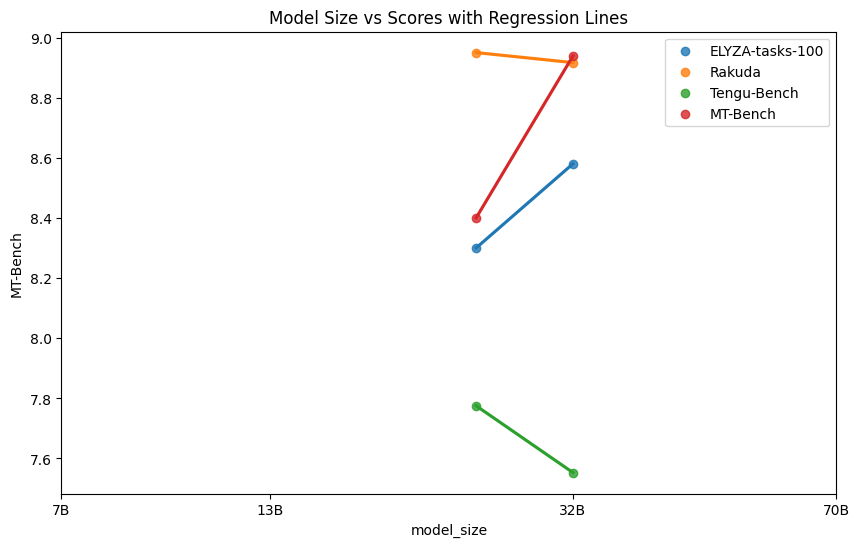

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

# 図のサイズを設定
plt.figure(figsize=(10, 6))

# データごとに違う色で散布図と回帰直線を描画
colors = ['blue', 'green', 'red', 'gold']  # 色を指定
for i, column in enumerate(['ELYZA-tasks-100', 'Rakuda', 'Tengu-Bench', 'MT-Bench']):
    sns.regplot(x='model_size', y=column, data=log_size_df, scatter=True, 
                label=column, ci=None, )


plt.xticks([log(7), log(13), log(32), log(70)], ["7B", "13B", "32B", "70B"])
# 凡例を表示
plt.legend()
# タイトルを設定
plt.title('Model Size vs Scores with Regression Lines')
# グラフを表示
# plt.savefig("model-size_vs_score.svg")
plt.show()


In [176]:
print(all_result_df[all_result_df['eval_dataset']=="Tengu-Bench"].groupby("Category").score.mean().sort_values(ascending=False).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
 & score \\
Category &  \\
\midrule
アイデア生成 & 10.000000 \\
プロジェクト作成 & 10.000000 \\
長い文書要約（千トークン以上） & 10.000000 \\
会話要約 & 9.966667 \\
フォーマット & 9.666667 \\
コスト見積 & 9.633333 \\
長い文書のClosed QA（千トークン以上） & 9.500000 \\
雑談 & 9.500000 \\
抽出 & 9.433333 \\
敬語 & 9.166667 \\
表の読み取り & 8.566667 \\
翻訳 & 8.033333 \\
数学 & 8.000000 \\
Function calling & 7.933333 \\
政治 & 7.200000 \\
法律判断 & 7.066667 \\
ビジネス & 6.433333 \\
建設 & 6.100000 \\
ダジャレ & 5.400000 \\
倫理的制御 & 5.133333 \\
日本 & 5.083333 \\
架空の質問 & 5.000000 \\
論理パズル & 5.000000 \\
\bottomrule
\end{tabular}



In [177]:
all_result_df.groupby(
    ["model_name", "eval_dataset"]
).score.mean().reset_index(drop=False).pivot_table(values="score", index="model_name", columns="eval_dataset")

eval_dataset,ELYZA-tasks-100,MT-Bench,Rakuda,Tengu-Bench
model_name,,,,
aya-expanse-32b-abliterated,4.06,8.700000,8.875,7.141667
gpt-4o,4.61,9.316667,9.900,8.516667
mistral-small-3.2-24b-instruct-2506,4.15,8.866667,9.450,7.866667
qwen3-32b,4.46,9.333333,8.750,7.950000
shisa-v2-mistral-small-24b,4.15,7.933333,8.450,7.683333
shisa-v2-qwen2.5-32b,4.35,8.783333,9.125,7.566667


In [178]:

mean_df = all_result_df.groupby(
    ["eval_dataset", "Category", "model_name"]
).score.mean().reset_index(level=1, drop=False).pivot_table(index='model_name', columns=['eval_dataset', 'Category'], values='score')


In [179]:
mean_df

eval_dataset                             Tengu-Bench                         \
Category                            Function calling アイデア生成 コスト見積 ダジャレ ビジネス   
model_name                                                                    
aya-expanse-32b-abliterated                      8.4   10.0   9.4  6.0  4.0   
gpt-4o                                           7.2   10.0   9.8  4.6  8.4   
mistral-small-3.2-24b-instruct-2506              8.4   10.0   9.8  4.0  6.8   
qwen3-32b                                        7.2   10.0   9.6  6.4  6.8   
shisa-v2-mistral-small-24b                       8.4   10.0   9.6  5.6  6.6   
shisa-v2-qwen2.5-32b                             8.0   10.0   9.6  5.8  6.0   

eval_dataset                                                          ...  \
Category                            フォーマット プロジェクト作成  会話要約 倫理的制御   建設  ...   
model_name                                                            ...   
aya-expanse-32b-abliterated           10.0     10.0  10.0   2.4  5.4  ...   
gpt-4o                                10.0     10.0  10.0   8.8  7.4  ...   
mistral-small-3.2-24b-instruct-2506    9.8     10.0  10.0   5.8  6.8  ...   
qwen3-32b                              9.6     10.0   9.8   4.6  5.8  ...   
shisa-v2-mistral-small-24b             9.6     10.0  10.0   3.4  6.0  ...   
shisa-v2-qwen2.5-32b                   9.0     10.0  10.0   5.8  5.2  ...   

eval_dataset                                                                 \
Category                               数学   日本 架空の質問 法律判断   翻訳 表の読み取り 論理パズル   
model_name                                                                    
aya-expanse-32b-abliterated           5.4  5.2   2.4  6.8  6.8    6.8   3.0   
gpt-4o                                8.6  7.5   8.4  8.6  8.6    9.0   3.8   
mistral-small-3.2-24b-instruct-2506   8.2  5.1   3.6  6.8  7.6    9.0   6.8   
qwen3-32b                            10.0  4.5   6.8  6.6  8.0    9.2   7.0   
shisa-v2-mistral-small-24b            7.8  4.6   5.2  6.8  9.0    8.4   3.8   
shisa-v2-qwen2.5-32b                  8.0  3.6   3.6  6.8  8.2    9.0   5.6   

eval_dataset                                                                 \
Category                            長い文書のClosed QA（千トークン以上） 長い文書要約（千トークン以上）   
model_name                                                                    
aya-expanse-32b-abliterated                             9.6            10.0   
gpt-4o                                                  9.2            10.0   
mistral-small-3.2-24b-instruct-2506                     9.4            10.0   
qwen3-32b                                               9.6            10.0   
shisa-v2-mistral-small-24b                              9.4            10.0   
shisa-v2-qwen2.5-32b                                    9.8            10.0   

eval_dataset                              
Category                              雑談  
model_name                                
aya-expanse-32b-abliterated          9.8  
gpt-4o                               9.8  
mistral-small-3.2-24b-instruct-2506  9.4  
qwen3-32b                            9.4  
shisa-v2-mistral-small-24b           9.4  
shisa-v2-qwen2.5-32b                 9.2  

[6 rows x 23 columns]

In [180]:
print(mean_df.to_markdown(index=True, floatfmt='.2f'))

| model_name                          |   ('Tengu-Bench', 'Function calling') |   ('Tengu-Bench', 'アイデア生成') |   ('Tengu-Bench', 'コスト見積') |   ('Tengu-Bench', 'ダジャレ') |   ('Tengu-Bench', 'ビジネス') |   ('Tengu-Bench', 'フォーマット') |   ('Tengu-Bench', 'プロジェクト作成') |   ('Tengu-Bench', '会話要約') |   ('Tengu-Bench', '倫理的制御') |   ('Tengu-Bench', '建設') |   ('Tengu-Bench', '抽出') |   ('Tengu-Bench', '政治') |   ('Tengu-Bench', '敬語') |   ('Tengu-Bench', '数学') |   ('Tengu-Bench', '日本') |   ('Tengu-Bench', '架空の質問') |   ('Tengu-Bench', '法律判断') |   ('Tengu-Bench', '翻訳') |   ('Tengu-Bench', '表の読み取り') |   ('Tengu-Bench', '論理パズル') |   ('Tengu-Bench', '長い文書のClosed QA（千トークン以上）') |   ('Tengu-Bench', '長い文書要約（千トークン以上）') |   ('Tengu-Bench', '雑談') |
|:------------------------------------|--------------------------------------:|----------------------------------:|--------------------------------:|------------------------------:|------------------------------:|----------------------------------:|---------------------------

In [181]:
mean_df

eval_dataset                             Tengu-Bench                         \
Category                            Function calling アイデア生成 コスト見積 ダジャレ ビジネス   
model_name                                                                    
aya-expanse-32b-abliterated                      8.4   10.0   9.4  6.0  4.0   
gpt-4o                                           7.2   10.0   9.8  4.6  8.4   
mistral-small-3.2-24b-instruct-2506              8.4   10.0   9.8  4.0  6.8   
qwen3-32b                                        7.2   10.0   9.6  6.4  6.8   
shisa-v2-mistral-small-24b                       8.4   10.0   9.6  5.6  6.6   
shisa-v2-qwen2.5-32b                             8.0   10.0   9.6  5.8  6.0   

eval_dataset                                                          ...  \
Category                            フォーマット プロジェクト作成  会話要約 倫理的制御   建設  ...   
model_name                                                            ...   
aya-expanse-32b-abliterated           10.0     10.0  10.0   2.4  5.4  ...   
gpt-4o                                10.0     10.0  10.0   8.8  7.4  ...   
mistral-small-3.2-24b-instruct-2506    9.8     10.0  10.0   5.8  6.8  ...   
qwen3-32b                              9.6     10.0   9.8   4.6  5.8  ...   
shisa-v2-mistral-small-24b             9.6     10.0  10.0   3.4  6.0  ...   
shisa-v2-qwen2.5-32b                   9.0     10.0  10.0   5.8  5.2  ...   

eval_dataset                                                                 \
Category                               数学   日本 架空の質問 法律判断   翻訳 表の読み取り 論理パズル   
model_name                                                                    
aya-expanse-32b-abliterated           5.4  5.2   2.4  6.8  6.8    6.8   3.0   
gpt-4o                                8.6  7.5   8.4  8.6  8.6    9.0   3.8   
mistral-small-3.2-24b-instruct-2506   8.2  5.1   3.6  6.8  7.6    9.0   6.8   
qwen3-32b                            10.0  4.5   6.8  6.6  8.0    9.2   7.0   
shisa-v2-mistral-small-24b            7.8  4.6   5.2  6.8  9.0    8.4   3.8   
shisa-v2-qwen2.5-32b                  8.0  3.6   3.6  6.8  8.2    9.0   5.6   

eval_dataset                                                                 \
Category                            長い文書のClosed QA（千トークン以上） 長い文書要約（千トークン以上）   
model_name                                                                    
aya-expanse-32b-abliterated                             9.6            10.0   
gpt-4o                                                  9.2            10.0   
mistral-small-3.2-24b-instruct-2506                     9.4            10.0   
qwen3-32b                                               9.6            10.0   
shisa-v2-mistral-small-24b                              9.4            10.0   
shisa-v2-qwen2.5-32b                                    9.8            10.0   

eval_dataset                              
Category                              雑談  
model_name                                
aya-expanse-32b-abliterated          9.8  
gpt-4o                               9.8  
mistral-small-3.2-24b-instruct-2506  9.4  
qwen3-32b                            9.4  
shisa-v2-mistral-small-24b           9.4  
shisa-v2-qwen2.5-32b                 9.2  

[6 rows x 23 columns]

In [182]:
mean_df = all_result_df.groupby(
    ["model_name", "eval_dataset"]
).score.mean().reset_index(level=1, drop=False)

In [183]:
mean_df['score_'] = mean_df.apply(lambda x: x.score*2 if x.eval_dataset=="ELYZA-tasks-100" else x.score, axis=1)

In [184]:
mean_df

,eval_dataset,score,score_
model_name,,,
aya-expanse-32b-abliterated,ELYZA-tasks-100,4.060000,8.120000
aya-expanse-32b-abliterated,MT-Bench,8.700000,8.700000
aya-expanse-32b-abliterated,Rakuda,8.875000,8.875000
aya-expanse-32b-abliterated,Tengu-Bench,7.141667,7.141667
gpt-4o,ELYZA-tasks-100,4.610000,9.220000
gpt-4o,MT-Bench,9.316667,9.316667
gpt-4o,Rakuda,9.900000,9.900000
gpt-4o,Tengu-Bench,8.516667,8.516667
mistral-small-3.2-24b-instruct-2506,ELYZA-tasks-100,4.150000,8.300000


In [185]:
unique_models = mean_df.index.unique()

In [190]:
import plotly.graph_objects as go
from plotly import offline
import plotly.express as px

# Get unique judge model(s) from the DataFrame
judge_models = all_result_df['judge_model'].unique()
judge_model_str = ', '.join(judge_models)

fig = go.Figure()

# Dynamically generate a color sequence using Plotly Express's palettes
color_sequence = px.colors.qualitative.Plotly
color_map = {model: color_sequence[i % len(color_sequence)] for i, model in enumerate(unique_models)}

for model_name in unique_models:
    model_mean_df = mean_df.loc[model_name]

    # Helper function to convert hex to an rgba string
    def hex_to_rgba(hex_color, opacity):
        hex_color = hex_color.lstrip('#')
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return f'rgba({r}, {g}, {b}, {opacity})'

    fig.add_trace(go.Scatterpolar(
        r=model_mean_df["score_"],
        theta=model_mean_df["eval_dataset"],
        fill='toself',
        name=model_name,
        mode='lines+markers',
        line=dict(color=color_map[model_name]),
        fillcolor=hex_to_rgba(color_map[model_name], 0.3),
        marker=dict(
            color=color_map[model_name],
            size=8,
            symbol='circle'
        ),
        hovertemplate=(
            "<b>%{fullData.name}</b><br><br>" +
            "Benchmark: %{theta}<br>" +
            "Score: %{r:.2f}<extra></extra>"
        )
    ))

fig.update_layout(
    title=dict(
        text=f"LLM Performance on Japanese Benchmarks<br><sup>Judge Model: {judge_model_str.replace('judge_', '')}</sup>",
        font=dict(size=20),
        x=0.5
    ),
    template='plotly_white',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10],
            showline=False,
            gridwidth=1
        ),
        angularaxis=dict(
            # The property is 'tickfont', not 'font'
            tickfont=dict(size=14)
        )
    ),
    legend=dict(
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        orientation='h',
        title=dict(text='Models', font=dict(size=12))
    ),
    font=dict(
        family="Arial, sans-serif",
        size=12
    )
)

fig.show()

# offline.plot(fig)


In [203]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Loop over all unique judge models and plot a 3x2 grid of horizontal bar graphs for each
for judge_model in all_result_df['judge_model'].unique():
    df_judge = all_result_df[all_result_df['judge_model'] == judge_model]
    mean_df_judge = df_judge.groupby([
        "model_name", "eval_dataset"
    ]).score.mean().reset_index()
    mean_df_judge['score_'] = mean_df_judge.apply(lambda x: x.score*2 if x.eval_dataset=="ELYZA-tasks-100" else x.score, axis=1)
    
    # Compute universal model order (best to worst overall)
    model_overall_scores = mean_df_judge.groupby('model_name')['score_'].mean().sort_values(ascending=False)
    model_order = model_overall_scores.index.tolist()
    color_sequence = go.Figure().layout.template.layout.colorway or ["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692", "#B6E880", "#FF97FF", "#FECB52"]
    color_map = {model: color_sequence[j % len(color_sequence)] for j, model in enumerate(model_order)}

    # Dynamically get all benchmarks present in the data
    benchmarks = mean_df_judge['eval_dataset'].unique()
    n_bench = len(benchmarks)
    if n_bench == 0:
        continue
    # Calculate average for each model
    avg_scores = mean_df_judge.groupby('model_name')['score_'].mean().reindex(model_order)
    # Set up 3x2 grid: first cell in 3rd row is average, others are benchmarks
    n_rows, n_cols = 3, 2
    subplot_titles = list(benchmarks)[:5]  # up to 5 benchmarks
    subplot_titles.insert(4, "Average")  # 5th cell (row 3, col 1) is Average
    while len(subplot_titles) < 6:
        subplot_titles.append("")
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.06, horizontal_spacing=0.05)
    bench_idx = 0
    for i in range(6):
        row = i // n_cols + 1
        col = i % n_cols + 1
        if i == 4:
            # Average bar (row 3, col 1)
            for j, model in enumerate(model_order):
                score = avg_scores.get(model, float('nan'))
                fig.add_trace(
                    go.Bar(
                        y=[""],
                        x=[score],
                        name=model,
                        marker_color=color_map[model],
                        text=[f"{score:.2f}" if pd.notnull(score) else ""],
                        textposition='outside',
                        orientation='h',
                        showlegend=(i == 0),
                    ),
                    row=row, col=col
                )
            fig.update_xaxes(range=[0, 10.5], row=row, col=col)
            fig.update_yaxes(showticklabels=False, autorange='reversed', row=row, col=col)
        elif bench_idx < n_bench:
            benchmark = benchmarks[bench_idx]
            df_bench = mean_df_judge[mean_df_judge['eval_dataset'] == benchmark].set_index('model_name')
            for j, model in enumerate(model_order):
                score = df_bench['score_'].get(model, float('nan'))
                fig.add_trace(
                    go.Bar(
                        y=[""],
                        x=[score],
                        name=model,
                        marker_color=color_map[model],
                        text=[f"{score:.2f}" if pd.notnull(score) else ""],
                        textposition='outside',
                        orientation='h',
                        showlegend=(i == 0),
                    ),
                    row=row, col=col
                )
            fig.update_xaxes(range=[0, 10.5], row=row, col=col)
            fig.update_yaxes(showticklabels=False, autorange='reversed', row=row, col=col)
            bench_idx += 1
    fig.update_layout(
        height=1200,
        width=1600,
        title_text=f"Comparison of Model Scores Across Benchmarks (with Average)\n(Judge Model: {judge_model.replace('judge_', '')})",
        title_x=0.5,
        template='plotly_white',
        font=dict(family="Arial, sans-serif", size=12),
        barmode='group',
        legend_title_text='Model',
        showlegend=True
    )
    fig.show()

In [204]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Loop over all unique judge models and plot a 3x2 grid of grouped bar graphs for each
for judge_model in all_result_df['judge_model'].unique():
    df_judge = all_result_df[all_result_df['judge_model'] == judge_model]
    mean_df_judge = df_judge.groupby([
        "model_name", "eval_dataset"
    ]).score.mean().reset_index()
    mean_df_judge['score_'] = mean_df_judge.apply(lambda x: x.score*2 if x.eval_dataset=="ELYZA-tasks-100" else x.score, axis=1)
    
    # Compute universal model order (best to worst overall)
    model_overall_scores = mean_df_judge.groupby('model_name')['score_'].mean().sort_values(ascending=False)
    model_order = model_overall_scores.index.tolist()
    color_sequence = go.Figure().layout.template.layout.colorway or ["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692", "#B6E880", "#FF97FF", "#FECB52"]
    color_map = {model: color_sequence[j % len(color_sequence)] for j, model in enumerate(model_order)}

    # Dynamically get all benchmarks present in the data
    benchmarks = mean_df_judge['eval_dataset'].unique()
    n_bench = len(benchmarks)
    if n_bench == 0:
        continue
    # Calculate average for each model
    avg_scores = mean_df_judge.groupby('model_name')['score_'].mean().reindex(model_order)
    # Set up 3x2 grid: first cell in 3rd row is average, others are benchmarks
    n_rows, n_cols = 3, 2
    subplot_titles = list(benchmarks)[:5]  # up to 5 benchmarks
    subplot_titles.insert(4, "Average")  # 5th cell (row 3, col 1) is Average
    while len(subplot_titles) < 6:
        subplot_titles.append("")
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.08, horizontal_spacing=0.05)
    bench_idx = 0
    for i in range(6):
        row = i // n_cols + 1
        col = i % n_cols + 1
        if i == 4:
            # Average bar (row 3, col 1)
            for j, model in enumerate(model_order):
                score = avg_scores.get(model, float('nan'))
                fig.add_trace(
                    go.Bar(
                        x=["Average"],
                        y=[score],
                        name=model,
                        marker_color=color_map[model],
                        text=[f"{score:.2f}" if pd.notnull(score) else ""],
                        textposition='outside',
                        showlegend=(i == 0),
                    ),
                    row=row, col=col
                )
            fig.update_yaxes(range=[0, 10.5], row=row, col=col)
        elif bench_idx < n_bench:
            benchmark = benchmarks[bench_idx]
            df_bench = mean_df_judge[mean_df_judge['eval_dataset'] == benchmark].set_index('model_name')
            for j, model in enumerate(model_order):
                score = df_bench['score_'].get(model, float('nan'))
                fig.add_trace(
                    go.Bar(
                        x=[benchmark],
                        y=[score],
                        name=model,
                        marker_color=color_map[model],
                        text=[f"{score:.2f}" if pd.notnull(score) else ""],
                        textposition='outside',
                        showlegend=(i == 0),
                    ),
                    row=row, col=col
                )
            fig.update_yaxes(range=[0, 10.5], row=row, col=col)
            bench_idx += 1
    fig.update_layout(
        height=1200,
        width=1400,
        title_text=f"Comparison of Model Scores Across Benchmarks (with Average) (Judge Model: {judge_model.replace('judge_', '')})",
        title_x=0.5,
        template='plotly_white',
        font=dict(family="Arial, sans-serif", size=12),
        barmode='group',
        legend_title_text='Model'
    )
    fig.show()

# Benchmark Descriptions

- **ELYZA-tasks-100**: A Japanese benchmark consisting of 100 diverse tasks, designed to evaluate general language understanding and generation capabilities of LLMs in Japanese. Tasks include question answering, summarization, and also translation evaluation.

- **Rakuda**: A Japanese benchmark focused on evaluating LLMs' performance on a wide range of question-answering tasks, including both factual and reasoning-based questions.

- **Tengu-Bench**: A comprehensive Japanese benchmark that tests LLMs on various categories such as knowledge, reasoning, and reading comprehension, aiming to provide a broad assessment of model capabilities.

- **MT-Bench**: The Japanese adaptation of the MT-Bench, which is a multi-turn dialogue benchmark. It evaluates LLMs' ability to handle conversational tasks, including context retention, instruction following, and multi-turn reasoning.

**Note:** Translation evaluation is included in ELYZA-tasks-100.
